# T3M40507.1 Programmentwurf

## Einleitung

Dieses Dokument beschreibt den Programmentwurf für die Aufgabe T3M40507.1.
Gegeben sind Daten von über 1000 Radfahrten mit einer Reihe von Messwerten.
Ziel ist es, ein Multi-Layer-Perceptron zu trainieren, welches die gefahrenen Höhenmeter vorhersagt.
Im Folgenden wird das Vorgehen beschrieben.
Anschließend werden die Daten analysiert und ein MLP erstellt und trainiert.
Zuletzt wird das MLP getestet und die Ergebnisse diskutiert.

## Vorgehen

Zunächst müssen die als zwei CSV-Dateien vorliegenden Daten eingelesen werden.
Anschließend werden die Daten explorativ analysiert, um sinnvolle Features zu finden.
Daraufhin werden die Daten bereinigt und gegebenenfalls normalisiert.

Im nächsten Schritt wird ein MLP erstellt und trainiert.
Abschließend wird das MLP getestet und die Ergebnisse diskutiert.

## Einlesen

Die Daten liegen in zwei CSV-Dateien vor.
Beide Dateien müssen korrekt eingelesen werden und die Daten müssen zusammengeführt werden.
Beim Einlesen muss darauf geachtet werden, dass die Gleitkomma-Werte korrekt eingelesen werden, da diese in der CSV-Datei mit einem Komma als Dezimaltrennzeichen vorliegen.

In [1]:
# imports
import pandas as pd
import numpy as np

In [2]:
# read the data
data = pd.read_csv('./data/myrides_Dataset_1.csv', sep='\t', index_col='date', decimal=',')
data2 = pd.read_csv('./data/myrides_Dataset_2.csv', sep='\t', index_col='date', decimal=',')

Die Datensätze haben grundsätzlich die gleiche Menge an Attributen, allerdings heißen zwei von ihnen unterschiedlich.
Nachdem die Attribute einheitlich benannt wurden, können die Datensätze zusammengeführt werden.

In [3]:
# rename the columns to match
data2 = data.rename(columns={'HR': 'heartrate', 'rpm_avg': 'rpm' })

# combine the data
data = pd.concat([data, data2])

Nach dem Zusammenführen der Daten liegen 1136 Datensätze vor.

In [4]:
print(f"Number of records: {len(data):.0f}.")
print(data.head())
print(data.dtypes)

Number of records: 1136.
            heartrate     Hm        km  maxElevation  max_speed  minElevation  \
date                                                                            
22.02.2020        NaN  959.6  56.02812         666.2    53.4096         313.4   
23.03.2020        NaN  444.0  16.43322         558.4    37.0836         342.0   
10.10.2018        NaN  250.2  35.19066         393.0    39.1680         266.2   
12.02.2017        NaN  310.8  24.47906         461.6    48.2688         236.0   
08.08.2018        NaN   28.4   3.23700         539.0    26.0676         514.0   

            position_lat_max  position_lat_min  position_long_max  \
date                                                                
22.02.2020         48.717180         48.584614           9.574801   
23.03.2020         48.756586         48.713941           9.516516   
10.10.2018         48.798283         48.703680           9.517267   
12.02.2017         48.766509         48.715440           9.561

## Analyse

Die Daten werden analysiert, um sinnvolle Features zu finden.
Hierzu werden die Daten zunächst auf ihre Vollständigkeit überprüft.
Womöglich liegen nicht für alle Attribute in allen Datensätzen Werte vor.
Hierzu wird das Package `missingno` verwendet.

<Axes: >

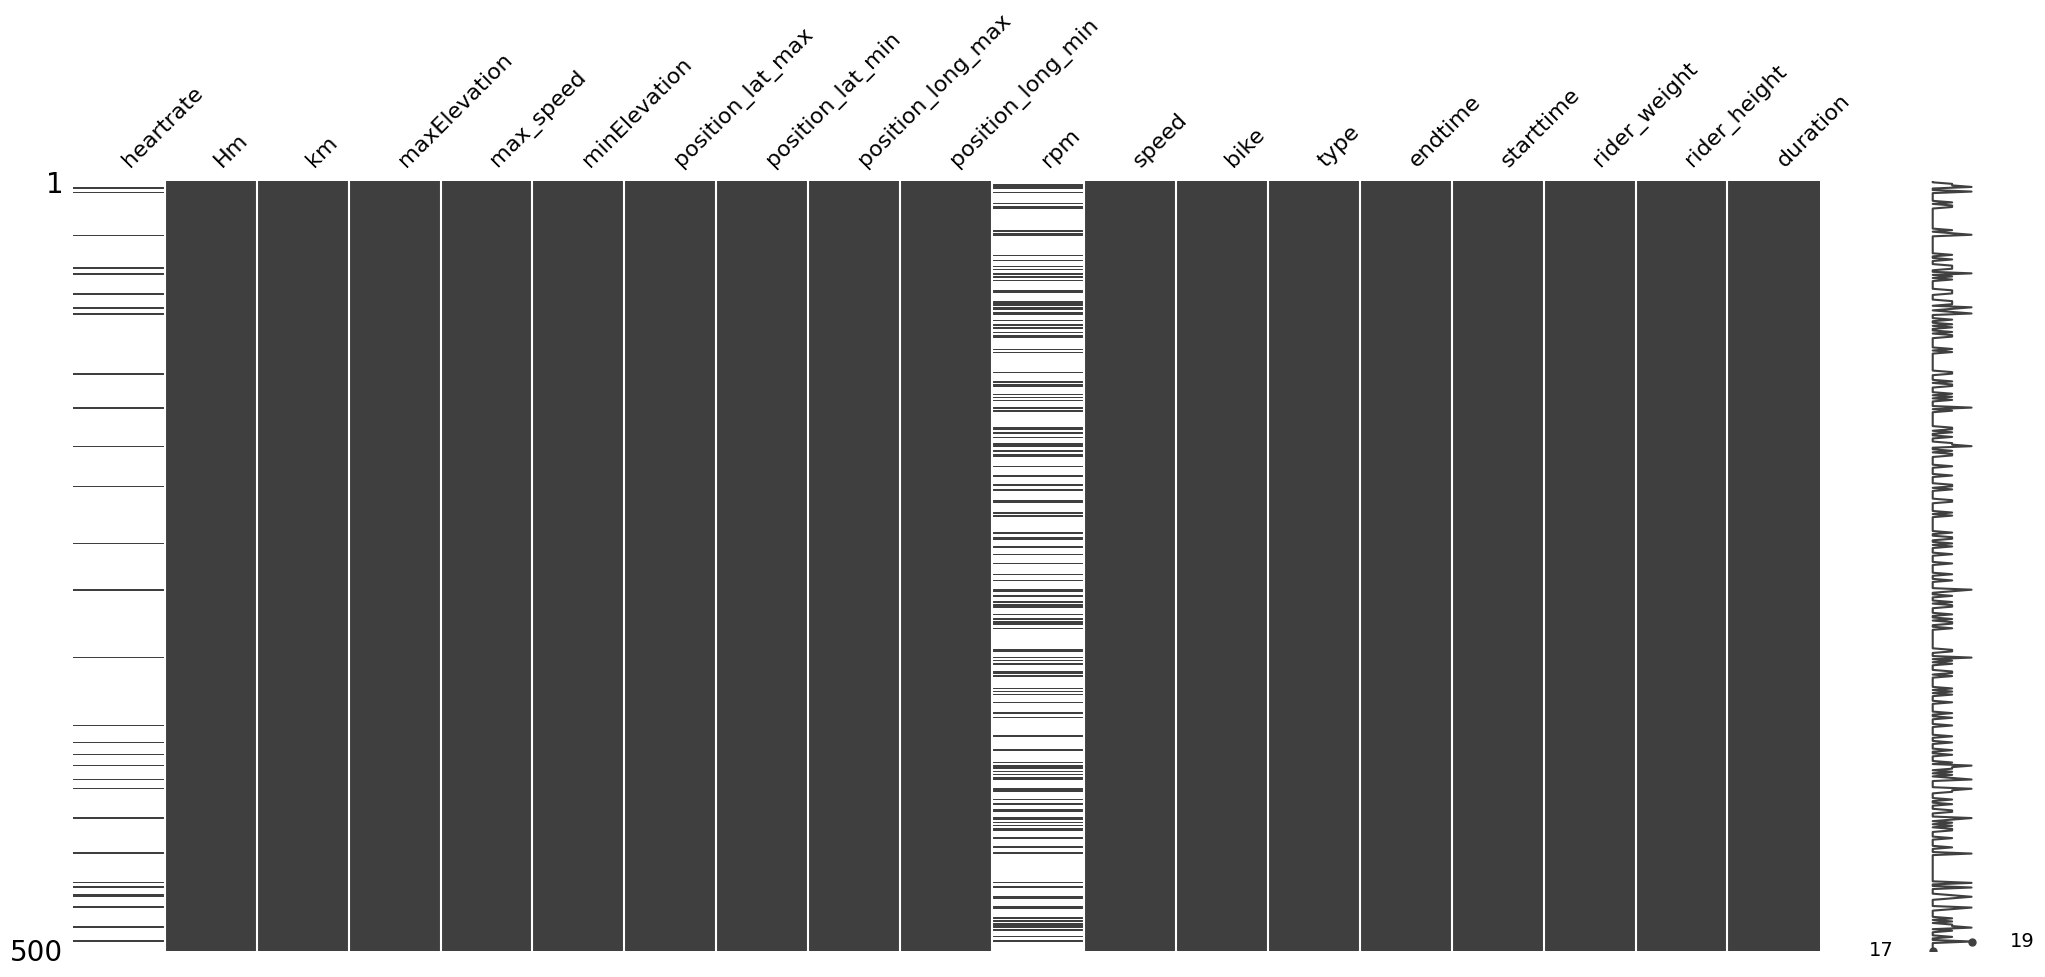

In [5]:
import missingno as msno

# check for missing data
msno.matrix(data.sample(500))

Die Ausgabe von `missingno` zeigt, dass für die Attribute `rpm` und `heartrate` nur sporadisch Werte vorliegen.
Eine Möglichkeit damit umzugehen, wäre die fehlenden Werte aus den vorhandenen zu interpolieren.
Hierzu sollten allerdings für mehr als die Hälfte der Datensätze Werte vorliegen.
Um dies zu überprüfen, errechnen wir das Verhältnis der Datensätze mit fehlenden Werten zur Anzahl aller Datensätze für die beiden Attribute.

In [6]:
def calc_missing_perc(attr): 
    return (data[attr].isna().sum() / len(data)) * 100

print(f"Missing RPM: {calc_missing_perc('rpm'):.2f}%")
print(f"Missing HR: {calc_missing_perc('heartrate'):.2f}%")

Missing RPM: 72.89%
Missing HR: 92.96%


Die Ausgabe zeigt, dass für das Attribut `rpm` für mehr als 70% der Datensätze keine Werte vorliegen und für das Attribut `heartrate` für mehr als 90% der Datensätze keine Werte vorliegen.
Die hohe Quote von fehlenden Werten macht es wenig sinnvoll diese zu interpolieren und auch das entfernen von Datensätzen mit fehlenden Werten würde den Datensatz zu stark verkleinern.
Daher werden die beiden Attribute nicht weiter betrachtet.

In [7]:
# remove columns with missing data
data.drop(columns={'heartrate', 'rpm'}, inplace=True)

Als nächstes werden die Daten auf mögliche Korrelationen mit der Zielgröße untersucht.
Doch zuvor muss das Attribut `duration` in ein numerisches Format umgewandelt werden.
Das Attribute stellt die Dauer der Fahrt in der Form `HH:MM:SS` dar.
Dieser Wert muss in Sekunden umgewandelt werden.

In [8]:
# convert durations to seconds
data['duration'] = pd.to_timedelta(data['duration'])
data['duration_s'] = data['duration'].dt.total_seconds()

data['starttime'] = pd.to_timedelta(data['starttime'])
data['starttime_s'] = data['starttime'].dt.total_seconds()

data['endtime'] = pd.to_timedelta(data['endtime'])
data['endtime_s'] = data['endtime'].dt.total_seconds()

Nach der Umwandlung sind die folgenden Attribute zu untersuchen:

- `Hm`: Die gefahrenen Höhenmeter. (Zielgröße)        
- `km`: Die gefahrenen Kilometer.
- `max_speed`: Die maximal erreichte Geschwindigkeit.
- `speed`: Die durchschnittliche Geschwindigkeit.
- `maxElevation`: Die maximal erreichte Höhe.
- `minElevation`: Die minimal erreichte Höhe.
- `position_lat_max`: Die maximale Breitengrad-Position.
- `position_lat_min`: Die minimale Breitengrad-Position.
- `position_long_max`: Die maximale Längengrad-Position.
- `position_long_min`: Die minimale Längengrad-Position.`
- `bike`: Name des verwendeten Rades.
- `type`: Typ des verwendeten Rades.
- `endtime_s`: Endzeitpunkt der Fahrt in Sekunden.
- `starttime_s`: Startzeitpunkt der Fahrt in Sekunden.
- `rider_weight`: Gewicht des Fahrers.
- `rider_height`: Größe des Fahrers.
- `duration_s`: Dauer der Fahrt in Sekunden.

Zunächst werden die Attribute, welche sich auf den Fahrer beziehen untersucht.

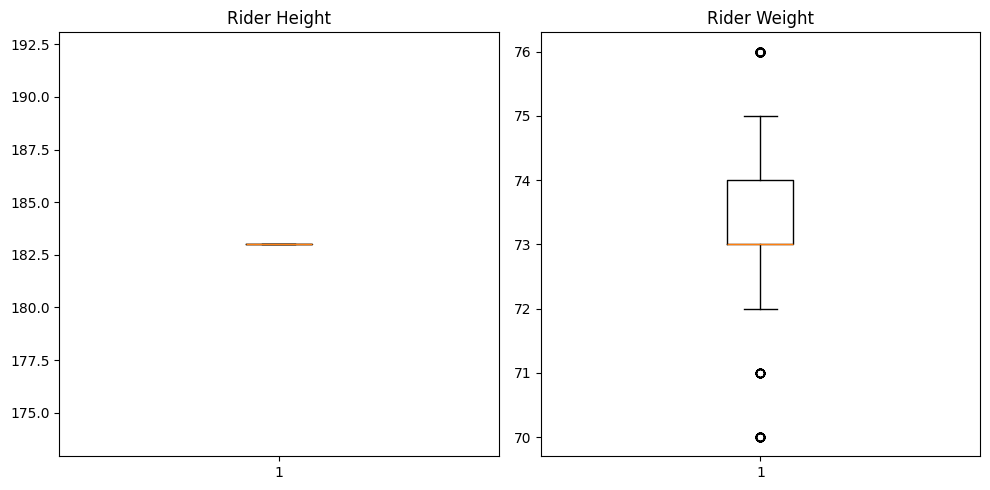

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(data['rider_height'])
axs[0].set_title('Rider Height')

axs[1].boxplot(data['rider_weight'])
axs[1].set_title('Rider Weight')

plt.tight_layout()
plt.show()

Die Höhe des Fahrers zeigt keine Variation, was darauf schließen lässt, dass alle Datensätze von einem Fahrer stammen.
Auch das Gewicht variiert nur geringfügig, was die Schlussfolgerung stützt.
Daher sind die beiden Attribute wenig nützlich für die Vorhersage der Zielgröße für andere Fahrer und werden folglich nicht weiter betrachtet.

Die Attribute, welche mit dem verwendeten Rad zu tun haben, könnten interessant sein. Zum Beispiel ist es denkbar, dass bei einer kurzen Fahrt mit dem Mountainbike mehr Höhenmeter gefahren werden, als mit anderen Rädern.

In [10]:
print(f"Bikes: {data['bike'].unique()}")
print(f"Types of bikes: {data['type'].unique()}")

Bikes: ['Rose PRO' 'Stevens Elite' 'CUBE AIM RACE' 'Carver Distaco 6000'
 'Mietrad - GHOST' 'Giant']
Types of bikes: ['Rennrad' 'Trecking' 'MTB']


Die Bezeichnungen der Räder im Attribut `bike` sind sehr spezifisch und wahrscheinlich wenig nützlich für die Vorhersage der Zielgröße für andere Räder.
Der Typ hingegen ist generischer und könnte interessant sein.
Daher werden bei den folgenden Betrachtungen der Typ berücksichtigt.

In [11]:
rennrad = data[data['type'] == 'Rennrad']
trecking = data[data['type'] == 'Trecking']
mtb = data[data['type'] == 'MTB']

Die zeitlichen Attribute `endtime`, `starttime` und `duration_s` sind wahrscheinlich interessant für die Vorhersage der Zielgröße.
Es ist denkbar, dass eher anstrengende Fahrten mit mehr Höhenmetern früher am Tag begonnen werden.
Darüber hinaus liegt eine Korrelation der Höhenmeter mit der Dauer der Fahrt nahe.

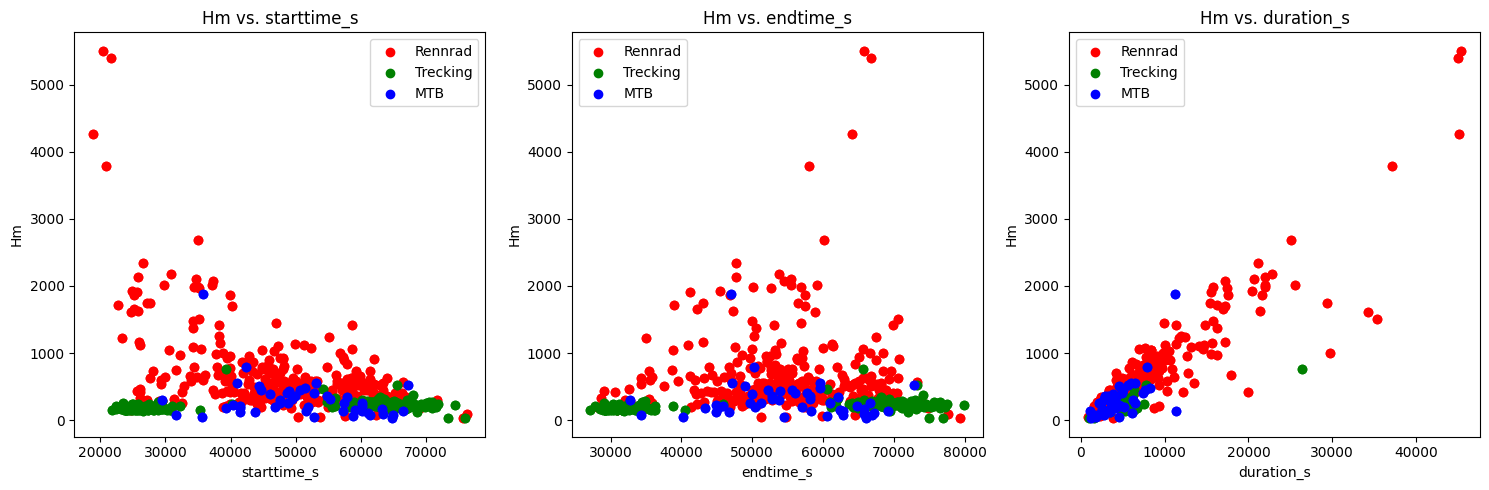

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(rennrad['starttime_s'], rennrad['Hm'], color = 'red', label='Rennrad')
axs[0].scatter(trecking['starttime_s'], trecking['Hm'], color = 'green', label='Trecking')
axs[0].scatter(mtb['starttime_s'], mtb['Hm'], color = 'blue', label='MTB')
axs[0].set_xlabel('starttime_s')
axs[0].set_ylabel('Hm')
axs[0].set_title('Hm vs. starttime_s')
axs[0].legend()

axs[1].scatter(rennrad['endtime_s'], rennrad['Hm'], color = 'red', label='Rennrad')
axs[1].scatter(trecking['endtime_s'], trecking['Hm'], color = 'green', label='Trecking')
axs[1].scatter(mtb['endtime_s'], mtb['Hm'], color = 'blue', label='MTB')
axs[1].set_xlabel('endtime_s')
axs[1].set_ylabel('Hm')
axs[1].set_title('Hm vs. endtime_s')
axs[1].legend()

axs[2].scatter(rennrad['duration_s'], rennrad['Hm'], color = 'red', label='Rennrad')
axs[2].scatter(trecking['duration_s'], trecking['Hm'], color = 'green', label='Trecking')
axs[2].scatter(mtb['duration_s'], mtb['Hm'], color = 'blue', label='MTB')
axs[2].set_xlabel('duration_s')
axs[2].set_ylabel('Hm')
axs[2].set_title('Hm vs. duration_s')
axs[2].legend()

plt.tight_layout()
plt.show()

Die Dauer der Fahrt zeigt wie erwartet einen klaren Zusammenhang mit den gefahrenen Höhenmetern.
Der Startzeitpunkt der Fahrt zeigt einen leichten Zusammenhang mit den gefahrenen Höhenmetern.
Fahrten mit mehr Höhenmetern werden eher früher am Tag begonnen.
der Endzeitpunkt der Fahrt hingegen zeigt keinen Zusammenhang mit den gefahrenen Höhenmetern.

Als nächstes werden die Attribute, welche sich auf die gefahrene Strecke beziehen untersucht.

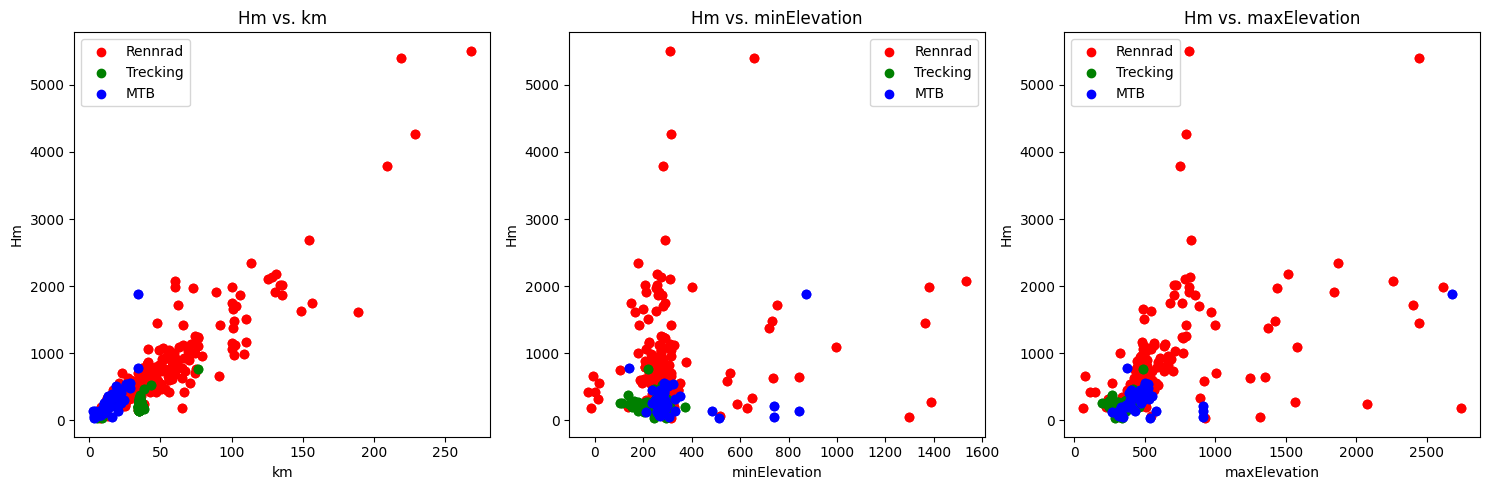

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(rennrad['km'], rennrad['Hm'], color = 'red', label='Rennrad')
axs[0].scatter(trecking['km'], trecking['Hm'], color = 'green', label='Trecking')
axs[0].scatter(mtb['km'], mtb['Hm'], color = 'blue', label='MTB')
axs[0].set_xlabel('km')
axs[0].set_ylabel('Hm')
axs[0].set_title('Hm vs. km')
axs[0].legend()

axs[1].scatter(rennrad['minElevation'], rennrad['Hm'], color = 'red', label='Rennrad')
axs[1].scatter(trecking['minElevation'], trecking['Hm'], color = 'green', label='Trecking')
axs[1].scatter(mtb['minElevation'], mtb['Hm'], color = 'blue', label='MTB')
axs[1].set_xlabel('minElevation')
axs[1].set_ylabel('Hm')
axs[1].set_title('Hm vs. minElevation')
axs[1].legend()

axs[2].scatter(rennrad['maxElevation'], rennrad['Hm'], color = 'red', label='Rennrad')
axs[2].scatter(trecking['maxElevation'], trecking['Hm'], color = 'green', label='Trecking')
axs[2].scatter(mtb['maxElevation'], mtb['Hm'], color = 'blue', label='MTB')
axs[2].set_xlabel('maxElevation')
axs[2].set_ylabel('Hm')
axs[2].set_title('Hm vs. maxElevation')
axs[2].legend()

plt.tight_layout()
plt.show()

Die gefahrenen Kilometer zeigen einen klaren Zusammenhang mit den gefahrenen Höhenmetern.
Allerdings zeigen weder die minimale noch die maximale erreichte Höhe einen klaren Zusammenhang mit den gefahrenen Höhenmetern.

Die Daten enthalten zusätzlich noch die "Bounding Box" der Fahrt also die maximale und minimale Breiten- und Längengrade, welche der Fahrer erreicht hat.
Während ein Zusammenhang zwischen der geographischen Position der Strecke und den gefahrenen Höhenmetern naheliegt, so ist es wahrscheinlich schwierig für das Modell diesen aus den vier Eingangswerten zu lernen.
Daher werden die beiden Attribute nicht weiter betrachtet.

Zuletzt werden die Attribute, welche mit der Geschwindigkeit zusammenhängen untersucht.

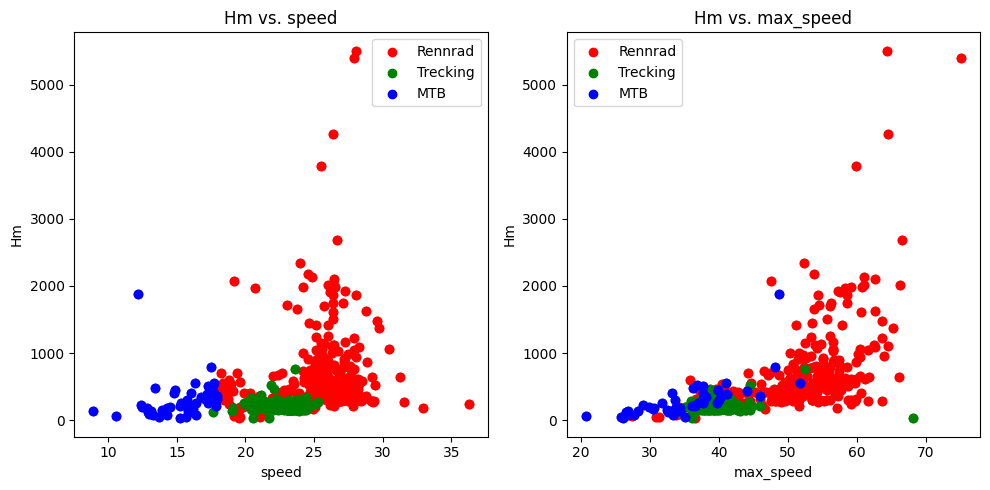

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(rennrad['speed'], rennrad['Hm'], color = 'red', label='Rennrad')
axs[0].scatter(trecking['speed'], trecking['Hm'], color = 'green', label='Trecking')
axs[0].scatter(mtb['speed'], mtb['Hm'], color = 'blue', label='MTB')
axs[0].set_xlabel('speed')
axs[0].set_ylabel('Hm')
axs[0].set_title('Hm vs. speed')
axs[0].legend()

axs[1].scatter(rennrad['max_speed'], rennrad['Hm'], color = 'red', label='Rennrad')
axs[1].scatter(trecking['max_speed'], trecking['Hm'], color = 'green', label='Trecking')
axs[1].scatter(mtb['max_speed'], mtb['Hm'], color = 'blue', label='MTB')
axs[1].set_xlabel('max_speed')
axs[1].set_ylabel('Hm')
axs[1].set_title('Hm vs. max_speed')
axs[1].legend()

plt.tight_layout()
plt.show()

Die Auswertung lassen einen leichten Zusammenhang zwischen der durchschnittlichen Geschwindigkeit und den gefahrenen Höhenmetern vermuten, wobei Fahrten mit vielen Höhenmetern sich bei einer Durchschnittsgeschwindigkeit von circa 25 km/h befinden.
Auch was die maximale Geschwindigkeit angeht, so ist ein leichter Zusammenhang mit den gefahrenen Höhenmetern zu erkennen.
Je mehr Höhenmeter gefahren werden, desto höher ist tendenziell auch die maximale Geschwindigkeit.

Als Ergebnis dieser Analyse werden die folgenden Attribute für das Training des MLPs verwendet:

- `km`: Die gefahrenen Kilometer.
- `max_speed`: Die maximal erreichte Geschwindigkeit.
- `speed`: Die durchschnittliche Geschwindigkeit.
- `duration_s`: Dauer der Fahrt in Sekunden.
- `type`: Typ des verwendeten Rades.
- `starttime_s`: Startzeitpunkt der Fahrt in Sekunden.

## Aufbereitung

Die Daten müssen aufbereitet werden, damit sie für das Training des MLPs verwendet werden können.
Das kategorische Attribute `type` muss in ein numerisches Format umgewandelt werden.
Hierzu wird der `OneHotEncoder` aus `scikit-learn` verwendet, welcher für jede Ausprägung des Attributs ein neues Attribut hinzufügt, in dem entweder eine `1` oder eine `0` steht, um anzugeben, ob die Ausprägung vorliegt oder nicht.

Des Weiteren müssen die numerischen Daten normalisiert werden, damit sie in einem ähnlichen Wertebereich liegen.
Hierzu wird der `StandardScaler` verwendet, welcher die Daten in den Wertebereich `[-1, 1]` skaliert.

In [15]:
# prepare data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

t = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type']),
    ('scaler', StandardScaler(), ['km', 'max_speed', 'speed', 'duration_s', 'starttime_s'])
], remainder='drop')

transform = pd.DataFrame(t.fit_transform(data))

features = transform
labels = data['Hm']

print('Features:')
print(features.head())
print("Labels:")
print(labels.head())

Features:
     0    1    2         3         4         5         6         7
0  0.0  1.0  0.0  0.570650  0.896464  0.552959  0.448581 -0.291634
1  0.0  1.0  0.0 -0.832546 -0.966317 -1.468058 -0.620831  0.538096
2  0.0  0.0  1.0 -0.167804 -0.728489 -0.917411 -0.097037  1.144110
3  0.0  1.0  0.0 -0.547411  0.309903  1.234922 -0.660495  0.602174
4  1.0  0.0  0.0 -1.300204 -2.223232 -2.234979 -1.048596  1.147725
Labels:
date
22.02.2020    959.6
23.03.2020    444.0
10.10.2018    250.2
12.02.2017    310.8
08.08.2018     28.4
Name: Hm, dtype: float64


## Training

Mit den aufbereiteten Daten kann nun ein MLP erstellt und trainiert werden.
Hierzu wird der `MLPRegressor` aus `scikit-learn` verwendet.

Zunächst werden die Daten in eine Menge für das Training und eine Menge für das Testen aufgeteilt.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print(X_train.head(10))

       0    1    2         3         4         5         6         7
12   0.0  0.0  1.0 -0.190360 -0.629086  0.221359 -0.250759 -1.221390
382  0.0  1.0  0.0 -0.672277 -1.016018 -1.269723 -0.502977 -0.018497
924  0.0  1.0  0.0  0.052280  0.662743  0.851477 -0.161183 -0.541308
536  0.0  0.0  1.0 -0.116786 -0.146036  0.003827 -0.202935  1.026009
318  0.0  1.0  0.0  0.679009  1.294898  0.725420  0.443647 -0.288216
286  0.0  1.0  0.0 -0.503695  0.314011  1.124655 -0.643794  0.734536
666  0.0  0.0  1.0 -0.166936 -0.862806 -0.472718 -0.195913  1.318139
986  0.0  0.0  1.0 -0.160357 -0.379757  0.134963 -0.275051  1.378734
789  0.0  1.0  0.0 -0.516739  0.076183  0.759408 -0.618743  0.261081
184  0.0  1.0  0.0  0.087069  0.773648  0.887873 -0.077300  0.896276


Anschließend wird das MLP erstellt.
Für den ersten Anlauf werden willkürlich gewählte Parameter verwendet.

In [17]:
from sklearn.neural_network import MLPRegressor

mlp_regressor = MLPRegressor(
  hidden_layer_sizes=(64, 32),
  random_state=42,
  max_iter=200
)


Anschließend kann das model mit dem Trainingsdatensatz trainiert werden.
Nachdem dies abgeschlossen ist kann das Modell eingesetzt werden um die Höhenmeter für den Testdatensatz vorherzusagen.

In [18]:
mlp_regressor.fit(X_train, y_train)

y_pred = mlp_regressor.predict(X_test)

/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Um die Qualität des Modells einzuschätzen können die Vorhersagen mit den tatsächlichen Werten gegenübergestellt werden.

            Actual    Predicted
date                           
10.05.2020   550.0   501.782076
19.05.2018   421.8   457.156462
03.04.2017   258.2   309.807024
08.04.2020   448.6   467.204576
15.07.2018  1223.8  1279.690168
13.07.2017   190.6   175.820392
22.07.2016  1974.4  1472.535565
12.06.2020  1243.4  1060.264591
14.12.2019   400.0   313.214706
08.05.2016   412.4   286.901065


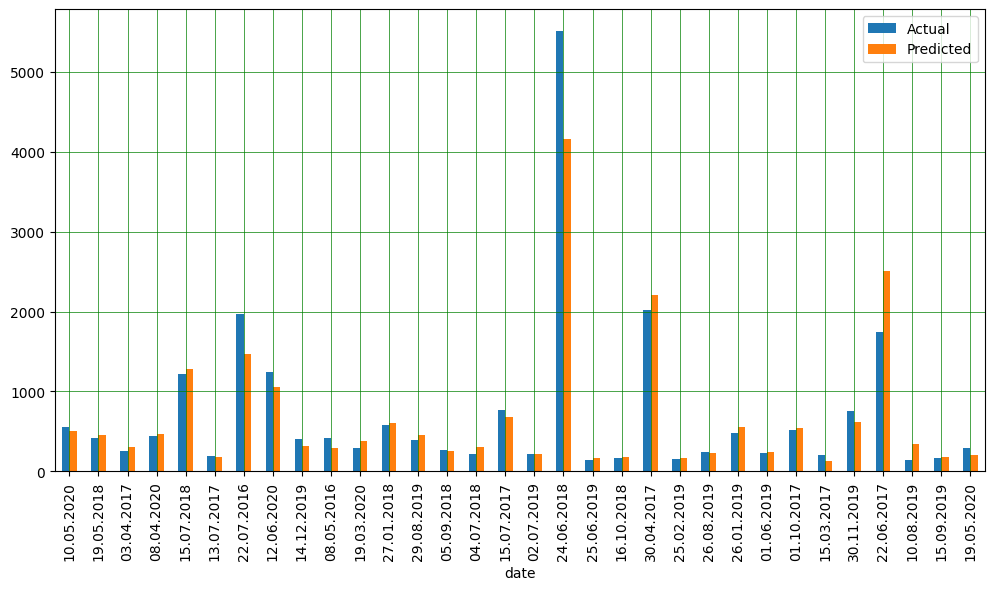

In [19]:
comp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(32)
print(comp.head(10))

comp.plot(kind='bar',figsize=(12,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Darüber hinaus kann die Qualität des Modells mit verschiedenen Indikatoren bewertet werden.
Hierzu werden der `mean_squared_error`, der `mean_absolute_error` und der `r2_score` errechnet.

In [20]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 103.70482217694297
Mean Squared Error: 40379.32535343333
Root Mean Squared Error: 200.94607573534083
R2 Score: 0.8931358852732236


Darüber hinaus können wir die Verlustkurve des Modells betrachten, um einen Eindruck zu erhalten, wie gut das Modell trainiert wurde.

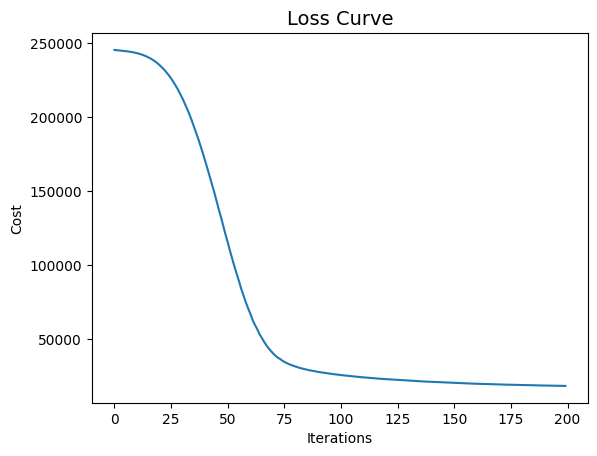

In [21]:
plt.plot(mlp_regressor.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## Optimierung

Um die Qualität des Modells zu verbessern, können verschiedene Parameter des MLPs optimiert werden.
Hierzu werden verschiedene Konfiguration des MLPs mit verschiedenen Parametern trainiert und mit einander verglichen.
Dieses Verfahren wird auch als "Hyperparameter Tuning" bezeichnet.

In [26]:
def grid_search():
    param_grid = {
        'hidden_layer_sizes': [(128,64), (64,32), (128,64,32), (64,32,16)],
        'max_iter': [100, 200, 400, 800, 1600],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate_init': [0.001, 0.01, 0.0005],
        'learning_rate': ['constant','adaptive'],
    }

    from sklearn.model_selection import GridSearchCV

    grid = GridSearchCV(mlp_regressor, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    return grid

# commented out because it takes a long time to run
grid = grid_search()
print(grid.best_params_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptro

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1600, 'solver': 'adam'}


Die Optimierung hat die folgenden Werte als optimale Parameter ergeben:

```python
{
  'activation': 'relu',
  'alpha': 0.05,
  'hidden_layer_sizes': (128, 64, 32),
  'learning_rate': 'constant',
  'learning_rate_init': 0.001,
  'max_iter': 1600,
  'solver': 'adam'
}
```

        Actual    Predicted
0   553.357311   501.782076
1   446.649510   457.156462
2   230.163744   309.807024
3   456.872450   467.204576
4  1436.641099  1279.690168
5   161.396485   175.820392
6  2124.223073  1472.535565
7  1114.201853  1060.264591
8   385.103331   313.214706
9   362.104638   286.901065


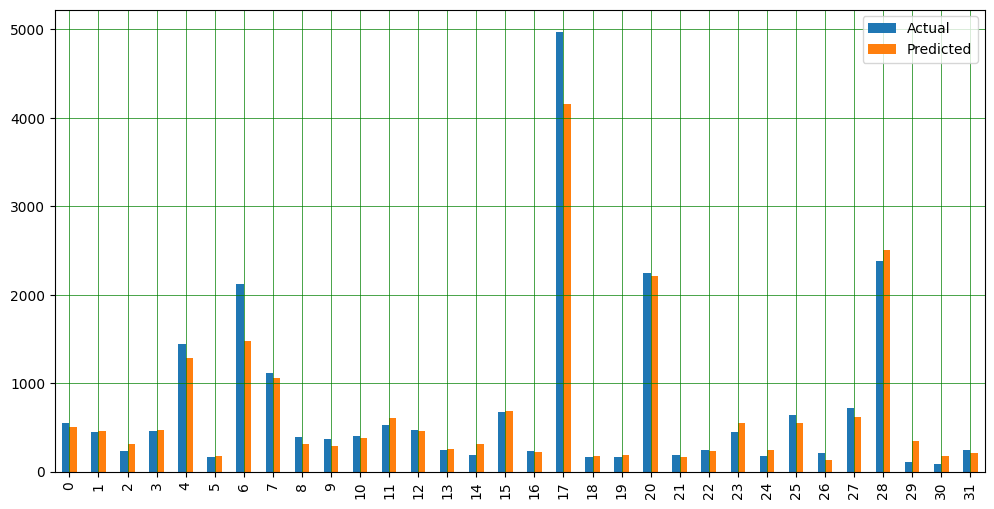

In [28]:
params = {
  'activation': 'relu',
  'alpha': 0.05,
  'hidden_layer_sizes': (128, 64, 32),
  'learning_rate': 'constant',
  'learning_rate_init': 0.001,
  'max_iter': 1600,
  'solver': 'adam',
  'random_state': 42
}

mlp_regressor = MLPRegressor(**params)
mlp_regressor.fit(X_train, y_train)

y_pred_grid = mlp_regressor.predict(X_test)

comp = pd.DataFrame({'Actual': y_pred_grid, 'Predicted': y_pred}).head(32)
print(comp.head(10))

comp.plot(kind='bar',figsize=(12,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

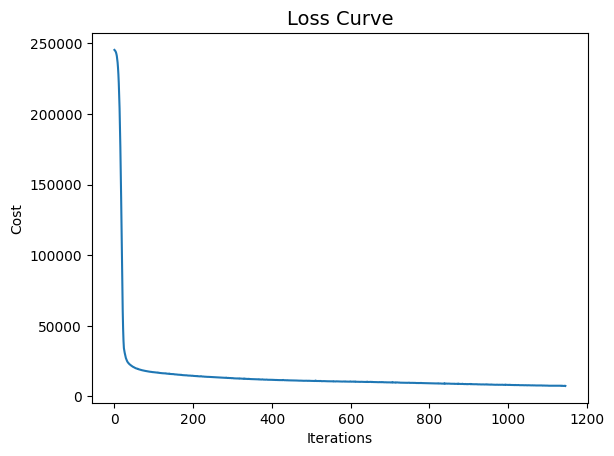

In [29]:
plt.plot(mlp_regressor.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [30]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_grid))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_grid))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_grid)))
print('R2 Score:', metrics.r2_score(y_test, y_pred_grid))

Mean Absolute Error: 78.21916998057462
Mean Squared Error: 18848.75146216717
Root Mean Squared Error: 137.29075519555994
R2 Score: 0.9501166718096676


## Diskussion

Das trainierte Modell erreicht einen R2-Score von `0.95` auf dem Testdatensatz.
Zudem weist es einen Mean Absolute Error (MAE) von 79 Höhenmetern auf.
Es verschätzt sich also im Schnitt um 79 Höhenmeter, was als relativ genau angesehen werden kann.
Tests mit neuen Datensätzen wären jedoch notwendig, um auszuschließen, dass das Modell über-angepasst ist.
